The dataset contain a list of passenger's data from year 1949 to 1960.

This data set contains 144 rows and 2 columns of data. It is a great dataset for time series analysis.


In [ ]:
# import the labraries
import numpy as np
import pandas as pd
import  seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


## Data Collection

In [4]:
air =pd.read_csv('/content/drive/MyDrive/AirPassengers.csv')

## Data Exploration and Understanding

In [17]:
air

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [13]:
air.shape

(144, 2)

In [10]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [11]:
air.isna().sum
air.isnull().sum()


,0
Month,0
#Passengers,0


In [12]:
air.describe()


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [15]:
air.columns

Index(['Month', '#Passengers'], dtype='object')

In [16]:
air.dtypes

,0
Month,object
#Passengers,int64


In [41]:
# Convert month into datetime
air['Month'] = pd.to_datetime(air['Month'])

In [44]:
air.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [42]:
air = air.set_index('Month')

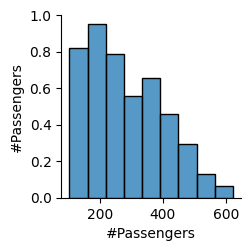

In [33]:
sns.pairplot(air)

<Axes: >

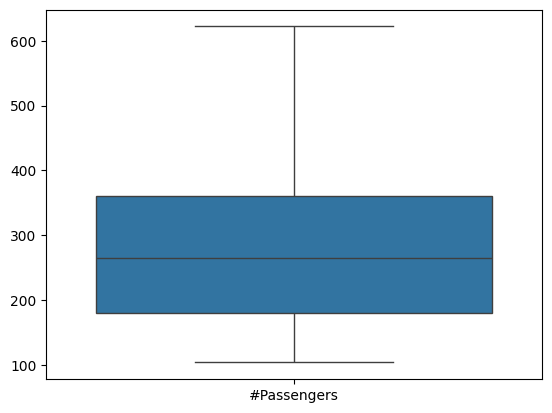

In [29]:
sns.boxplot(air)

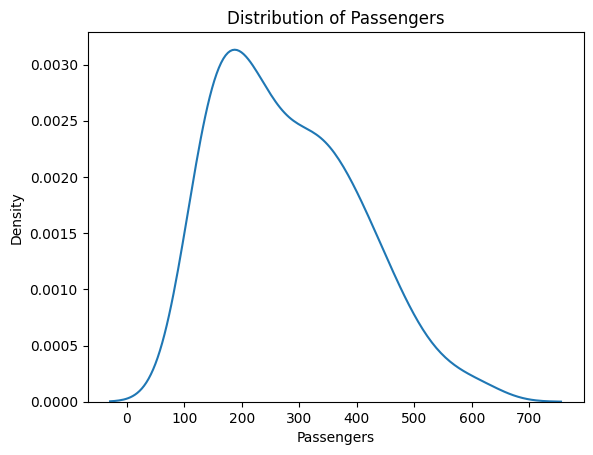

In [35]:
sns.kdeplot(air['#Passengers'])
plt.xlabel('Passengers')
plt.ylabel('Density')
plt.title('Distribution of Passengers')
plt.show()


In [37]:
from scipy import stats

# Shapiro-Wilk test for normality
statistic, p_value = stats.shapiro(air['#Passengers'])
print(f'Shapiro-Wilk test: statistic={statistic:.3f}, p-value={p_value:.3f}')

# Other tests for different distributions can be used as needed

Shapiro-Wilk test: statistic=0.952, p-value=0.000


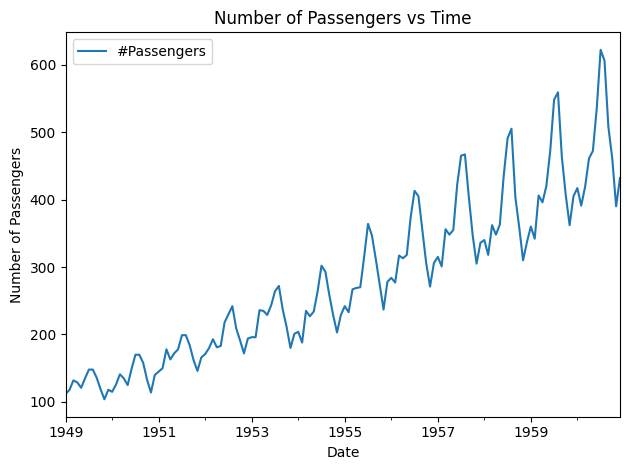

In [45]:
air.plot()
plt.title("Number of Passengers vs Time")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.tight_layout()
plt.show()

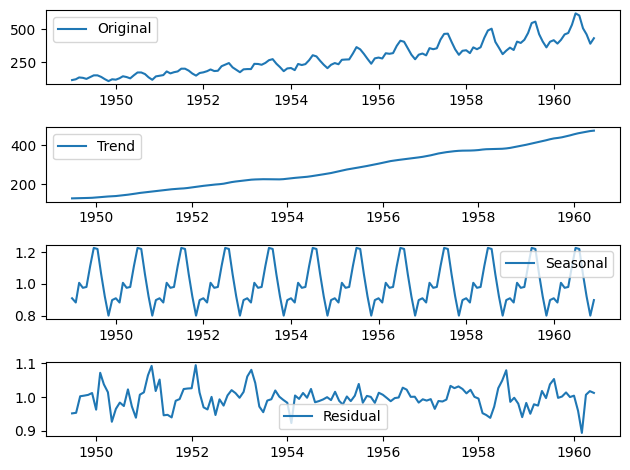

In [54]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposed = seasonal_decompose(air, model = 'multiplicative',period=12)

# Access the individual components
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plot the original time series
plt.subplot(411)
plt.plot(air, label='Original')
plt.legend()

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


A few things that we can draw from the decomposer:

There is a noticable upward trend

There is seasonality, which will make SARIMA a better choice than ARIMA

Residual plot doesn't show any trend or seasonality, so the decomposer is working fine

In [105]:
from statsmodels.tsa.stattools import adfuller
# Create a function to test the stationarity of the time-series
def stationarity_test(series):
    result = adfuller(series)
    p_val = result[1]

    # Interpret test result
    if p_val < 0.05:
        print('The time-series is stationary (reject the null hypothesis).')
    else:
        print('The time-series is non-stationary (fail to reject the null hypothesis).')

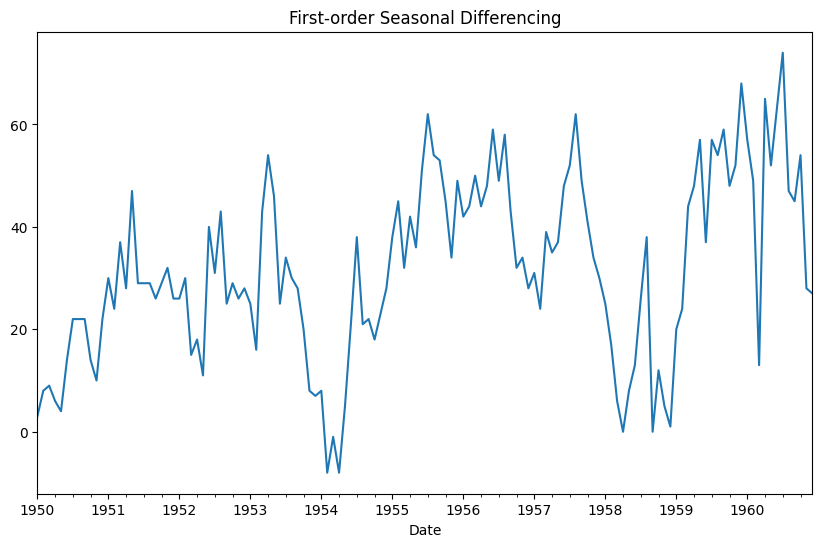

In [106]:
# First-order seasonal differencing (for the parameter D)
fig, ax = plt.subplots(figsize=(10, 6))
diff_1s = air['#Passengers'].diff(12).dropna()
diff_1s.plot(xlabel='Date')
plt.title('First-order Seasonal Differencing')
plt.show()

The first seasonal difference is still seasonal, plus, there still appears to be a trend in our differenced time-series. An additional non-seasoning differencing is needed.

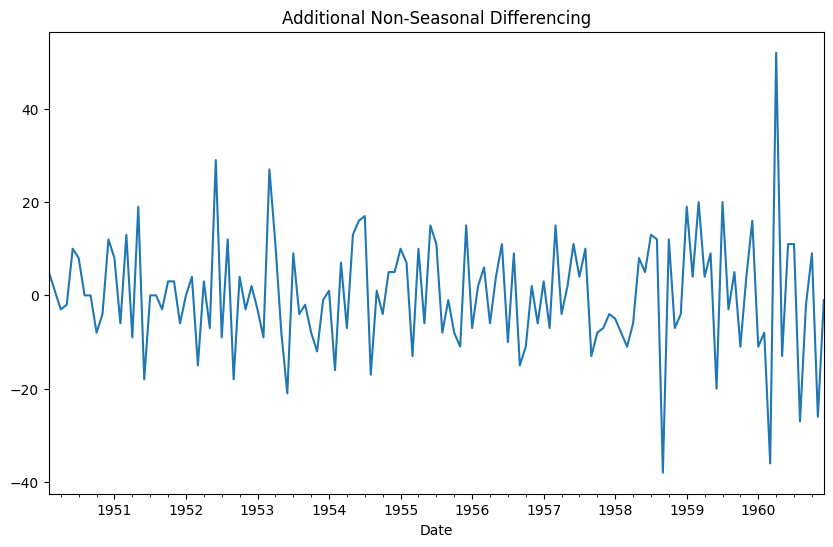

In [108]:
# Additional non-seasonal differencing (for the parameter d)
fig, ax = plt.subplots(figsize=(10, 6))
diff_1s_1r = diff_1s.diff(1).dropna()
diff_1s_1r.plot(xlabel='Date')
plt.title('Additional Non-Seasonal Differencing')
plt.show()


It looks random enough with a constant mean around 0.

In [113]:
# Stationarity test using adfuller
stationarity_test(diff_1s_1r.values)

p_val = adfuller(diff_1s_1r.values)[1]
p_val

The time-series is stationary (reject the null hypothesis).


1.856511600123444e-28

Our diffed time-series is now stationary. I think the potential model should be ARIMA(p,1,q)x(P,1,Q)12.

In [114]:
air['Month'] = air.index.month
air['Year'] = air.index.year

# Get unique years
years = air['Year'].unique()

# Create a colormap for the years
colors = cm.rainbow_r([i / len(years) for i in range(len(years))])

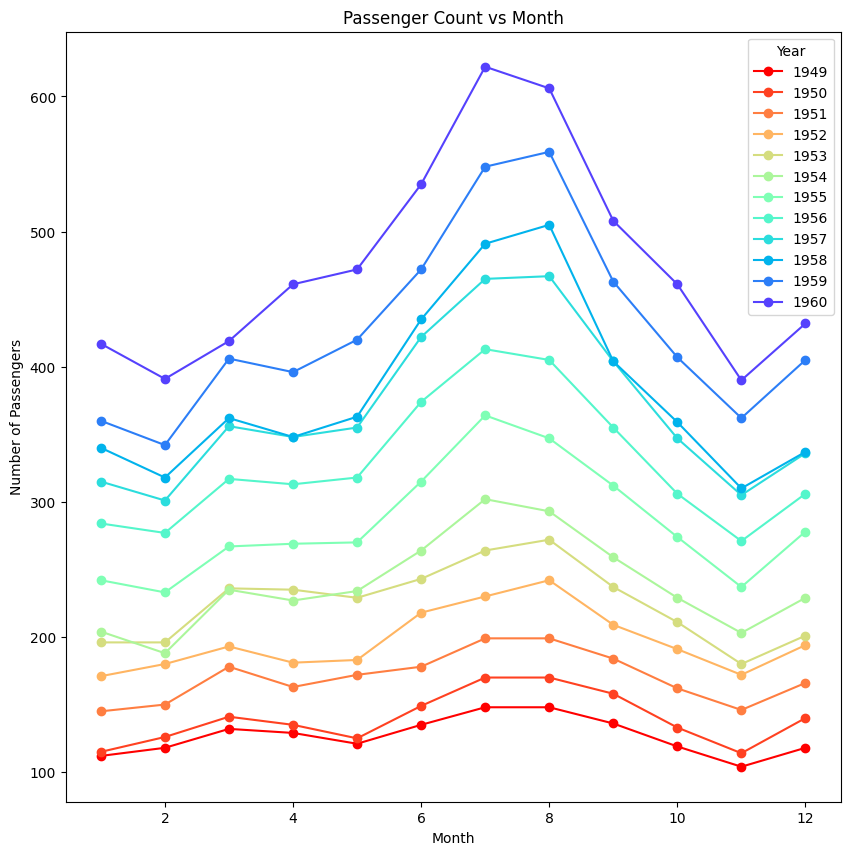

In [64]:
fig, ax = plt.subplots(figsize=(10,8) )

for year, color in zip(years, colors):
    data = air[air['Year'] == year]
    ax.plot(data['Month'], data['#Passengers'], label=str(year), color=color, marker='o')

ax.set_xlabel('Month')
ax.set_ylabel('Number of Passengers')
ax.set_title('Passenger Count vs Month')
ax.legend(title='Year')
plt.show()

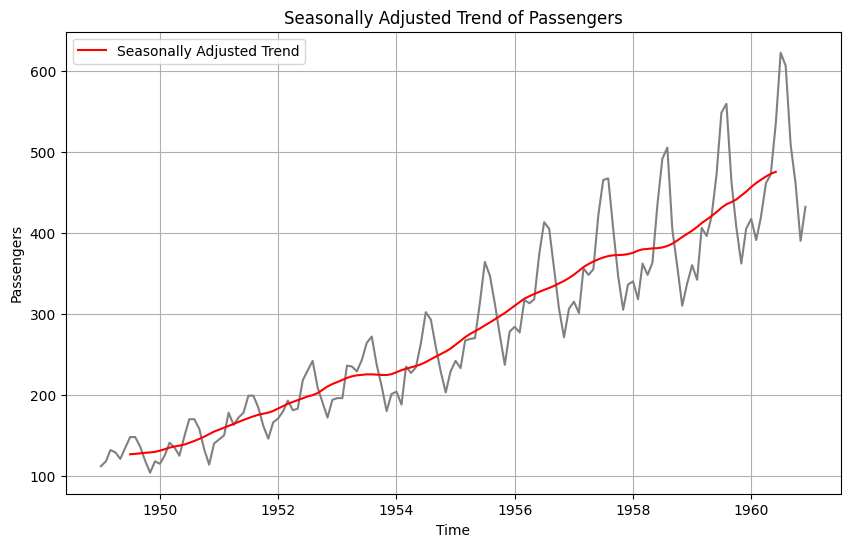

In [115]:

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(air['#Passengers'], model='additive', period=12)

# Extract the trend component
trend = decomposition.trend

# Plot the seasonally adjusted trend
plt.figure(figsize=(10, 6))
plt.plot(air.index, air['#Passengers'], color='gray')
plt.plot(trend, label='Seasonally Adjusted Trend', color = 'red')
plt.title('Seasonally Adjusted Trend of Passengers')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

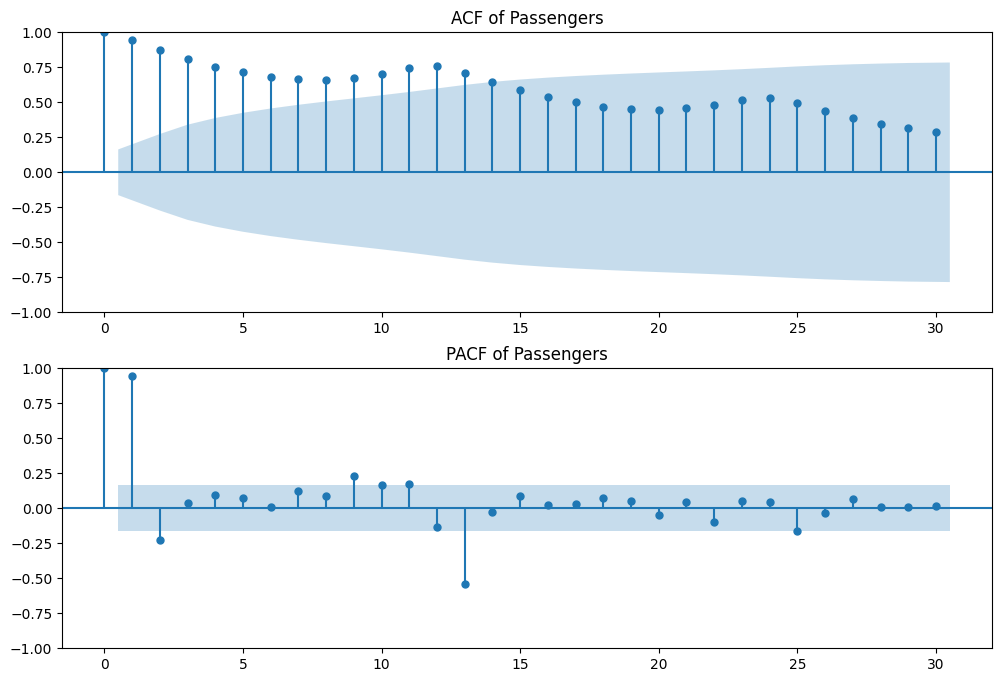

In [116]:
# Assuming 'air' is your DataFrame and '#Passengers' is your time series column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
sm.graphics.tsa.plot_acf(air['#Passengers'], lags=30, ax=ax1)
ax1.set_title('ACF of Passengers')

# PACF plot
sm.graphics.tsa.plot_pacf(air['#Passengers'], lags=30, ax=ax2)
ax2.set_title('PACF of Passengers')

plt.show()

# Build Model
Split data into train and test

In [163]:
# Split
y = air['#Passengers']
cutoff_split = int(len(y)*0.8)
y_train = y.iloc[:cutoff_split]
y_test = y.iloc[cutoff_split:]

In [164]:
# Base MSE
y_pred_baseline = [y_train.mean()]*len(y_train)
y_train_mse = mean_squared_error(y_train, y_pred_baseline)
print(f'Base MSE: {y_train_mse}')

Base MSE: 8271.858147448016


## Iterate

In [165]:
# Find the best parameters using Auto Arima but based on our potential model
arima = auto_arima(y_train,
                   start_p=0, max_p= 1,
                   d=1, max_d= 1,
                   start_q=0, max_q= 1,
                   start_P=0, max_P= 1,
                   D=1,max_D= 1,
                   start_Q=0, max_Q= 1,
                   m=12,
                   seasonal=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=False,
                   n_fits=100,
                   trace=True
                   )

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=756.166, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=758.107, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.18 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=756.629, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=756.406, Time=0.16 sec
 ARIMA(1,1

In [166]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -375.750
Date:                            Thu, 24 Oct 2024   AIC                            755.499
Time:                                    16:06:03   BIC                            760.749
Sample:                                01-01-1949   HQIC                           757.625
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048      0.090     -2.271      0.023      -0.382      -0.028
sigma2        92.6974     13.326      6.956      0.000      66.579     118.816
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.87   Prob(JB):                         0.30
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [167]:
# Find the best parameters using Auto Arima but based on our potential model
free_arima = auto_arima(y_train,
                   start_p=0, max_p= 3, # Bigger range will let us find better but more complex model
                   d=1, max_d= 1,
                   start_q=0, max_q= 3,
                   start_P=0, max_P= 3,
                   D=1,max_D= 1,
                   start_Q=0, max_Q= 3,
                   m=12,
                   seasonal=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=False,
                   n_fits=100,
                   trace=True
                   )

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.09 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.47 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.56 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.18 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.61 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.60 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.31 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=3.12 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.38 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=2.46 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.98 sec
 ARIMA(0,1,1)(0,1,0)[1

In [169]:
free_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Thu, 24 Oct 2024   AIC                            752.557
Time:                                            16:09:14   BIC                            768.307
Sample:                                        01-01-1949   HQIC                           758.934
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

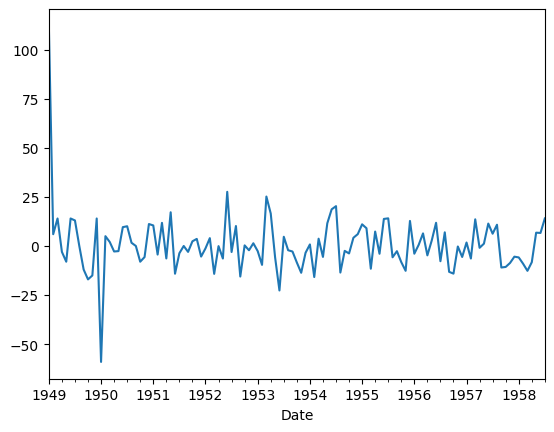

In [170]:
# Plot residuals to check for trends or patterns
arima.resid().plot(xlabel='Date')

## Evaluate

In [171]:
# Rolling validation (walk-forward validation)
test_size = int(len(y_test))
prediction = []
for i in range(test_size):
    train = y.iloc[:-(test_size-i)]
    model = SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,0,12)).fit()
    next_pred = model.forecast(steps=1)
    prediction.append(next_pred.iloc[0])

y_wfv = pd.Series(prediction, index=y_test.index)
y_wfv.head()


,0
Month,
1958-08-01,490.337911
1958-09-01,439.772881
1958-10-01,355.658336
1958-11-01,314.133631
1958-12-01,342.701854


In [172]:
# Comparison between models' MSEs and Baseline model's MSE
print(f'Base MSE: {round(y_train_mse, 2)}')

y_wfv_mse = mean_squared_error(y_test, y_wfv)
print(f'Test MSE: {round(y_wfv_mse, 2)}')

Base MSE: 8271.86
Test MSE: 301.0


## Communicate Results

In [173]:

# Create a DataFrame from y_test and y_wfv for easier comparison
y_test_and_pred = pd.DataFrame({
    'y_test': y_test,
    'y_wfv': y_wfv,
})
y_test_and_pred.head()

,y_test,y_wfv
Month,,
1958-08-01,505,490.337911
1958-09-01,404,439.772881
1958-10-01,359,355.658336
1958-11-01,310,314.133631
1958-12-01,337,342.701854


<Figure size 1000x600 with 0 Axes>

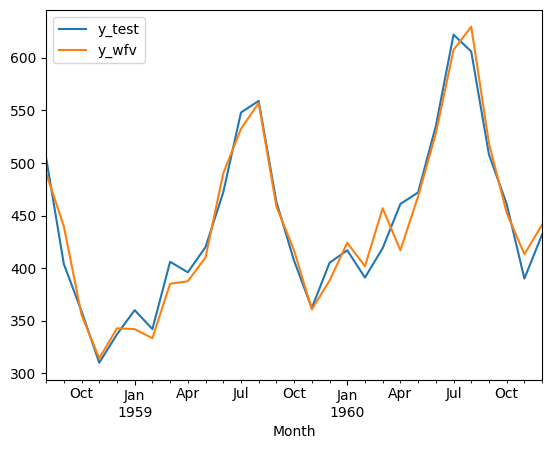

In [177]:
# Visual comparison of y_test and y_wfv
plt.figure(figsize=(10, 6))
y_test_and_pred.plot()
plt.legend(loc='upper left');

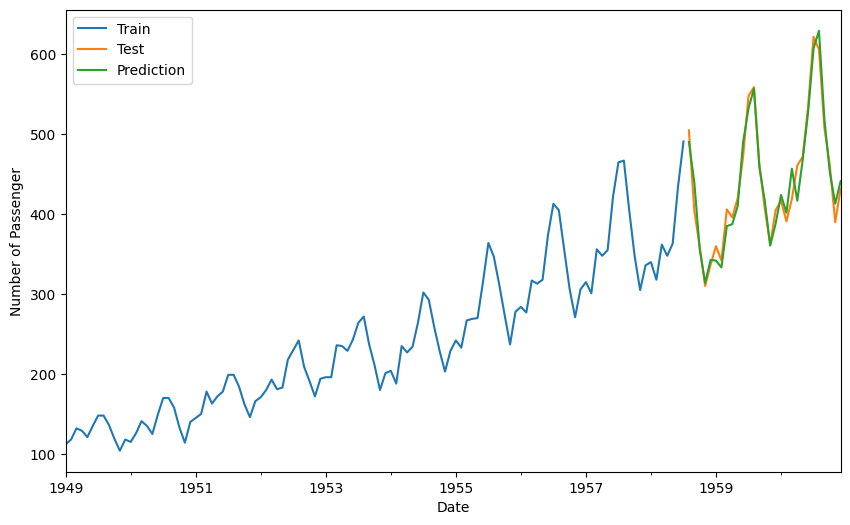

In [176]:
# Visualization of true data and model's prediction
plt.figure(figsize=(10, 6))
y_train.plot(label='Train')
y_test.plot(label='Test')
y_wfv.plot(label='Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Passenger')
plt.legend();

The "free" model has a higher accuracy (lower AIC indicates better fit), but it is also more complex (higher BIC indicates the higher complexity).



In [179]:
import joblib

# Save model
model = SARIMAX(y_train, order=(1,1,0), seasonal_order=(0,1,0,12)).fit()
modelname = 'air_passenger_SARIMAX.pkl'
joblib.dump(model, modelname)

['air_passenger_SARIMAX.pkl']

In [180]:
# Load model
modelname = 'air_passenger_SARIMAX.pkl'
sarima_model = joblib.load(modelname)

In [189]:
# Create a predictor function
def Air_Passenger_Predictor(modelname, start_date, end_date, dynamic=False, return_series=False):

    """
    Generate predictions using a SARIMA model.

    Parameters:
    - model: Fitted SARIMA model.
    - start_date: Start date for the prediction period.
    - end_date: End date for the prediction period.
    - dynamic: Whether to use dynamic forecasting (default: False).
    - return_series: Whether the output will be returned as a Series or just an array of values

    Returns:
    - predictions: Predicted values.
    """

    model = joblib.load(modelname)

    # Generate the date range for prediction
    prediction_dates = pd.date_range(start=start_date, end=end_date, freq='M')

    # Generate predictions
    if dynamic:
        predictions = model.predict(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=True)
    else:
        predictions = model.predict(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), dynamic=False)
    # When you set dynamic=True, the model continuously predicts one-step ahead (t+1) and then for the 2nd step ahead (t+2) prediction, it appends predicted value (t+1) to data, re-fits model on new expanded data then makes 2nd step ahead forecast. This is called out-of-sample prediction.

    # When you set dynamic=False, the model sequentially predicts one-step-ahead using the true value from previous time step instead of using predicted value. This is called in-sample prediction.

    # Extract and return predicted values
    predicted_values = predictions.values

    if return_series:
        return predictions
    else:
        return predicted_values



In [190]:
# Test model
import datetime as dt
today = dt.datetime.now()
last_month = today - dt.timedelta(days=30)

Air_Passenger_Predictor(modelname, last_month, today, return_series=True)

,predicted_mean
2024-10-01,1940.936939
2024-11-01,1898.959798


  # Summary

  Comparison:

The Test MSE (1013.48) is significantly lower than the Baseline MSE (2629.12). This indicates that SARIMA model performs much better than simply predicting the average.

Interpretation:

A lower MSE suggests better predictive accuracy. In this case, the substantial reduction in MSE from baseline to the SARIMA model implies that the model effectively captures the underlying patterns in the data and generates more accurate predictions.

Conclusion:

Based on the comparison of MSE values and visualizations,  SARIMA model demonstrates a good level of performance in predicting the number of passengers. It effectively captures the trends and seasonality present in the data, resulting in improved accuracy compared to the baseline approach.


##The model fit the data reasonably well.